# sample_preprocessing_layers_of_structured_data_from_scratch
- ref: https://keras.io/examples/structured_data/structured_data_classification_from_scratch/
- ref: https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/guide/keras/preprocessing_layers.ipynb
- ref: https://tensorflow.google.cn/guide/keras/preprocessing_layers?hl=ja
- ref: https://tensorflow.classcat.com/2021/01/14/tf24-guide-keras-preprocessing-layers/
- ref: https://www.tensorflow.org/api_docs/python/tf/keras/layers/IntegerLookup

In [24]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import layers

## prepare dataset

- csvのロード

In [3]:
file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
dataframe = pd.read_csv(file_url)
dataframe.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


- train/validの分割。

In [4]:
val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
train_dataframe = dataframe.drop(val_dataframe.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)

Using 242 samples for training and 61 for validation


- ds作成
  - dict(dataframe)なこれでいいのか？感がある。
    - dictだと列志向のdictになる。この変換でOKなのは覚えておいた方が良い。
  - shuffleのbuffer_sizeの意味を知らない。
    - 基本は、データサイズと同じにすれば均等にシャッフルできる。
    - 詳しくはこちら。https://qiita.com/exy81/items/d1388f6f02a11c8f1d7e

In [44]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe[['sex','cp']]), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

- dsの値を確認。

In [45]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'sex': <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1], dtype=int64)>, 'cp': <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([1, 4, 2, 3, 4, 3, 2, 3, 3, 2, 3, 4, 2, 2, 0, 4, 3, 4, 4, 4, 4, 1,
       4, 4, 3, 4, 2, 4, 4, 4, 4, 3], dtype=int64)>}
Target: tf.Tensor([0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 1 0 1 0 1 1 0 1 0], shape=(32,), dtype=int64)


In [46]:
def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = layers.Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):

    lookup_class = layers.StringLookup if is_string else layers.IntegerLookup

    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

In [47]:
sex = keras.Input(shape=(1,), name="sex", dtype="int64")
cp = keras.Input(shape=(1,), name="cp", dtype="int64")
all_inputs = [
    sex,
    cp,
]

sex_encoded = encode_categorical_feature(sex, "sex", train_ds, False)
cp_encoded = encode_categorical_feature(cp, "cp", train_ds, False)

all_features = layers.concatenate(
    [
        sex_encoded,
        cp_encoded,
    ]
)

x = layers.Dense(32, activation="relu")(all_features)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(all_inputs, output)

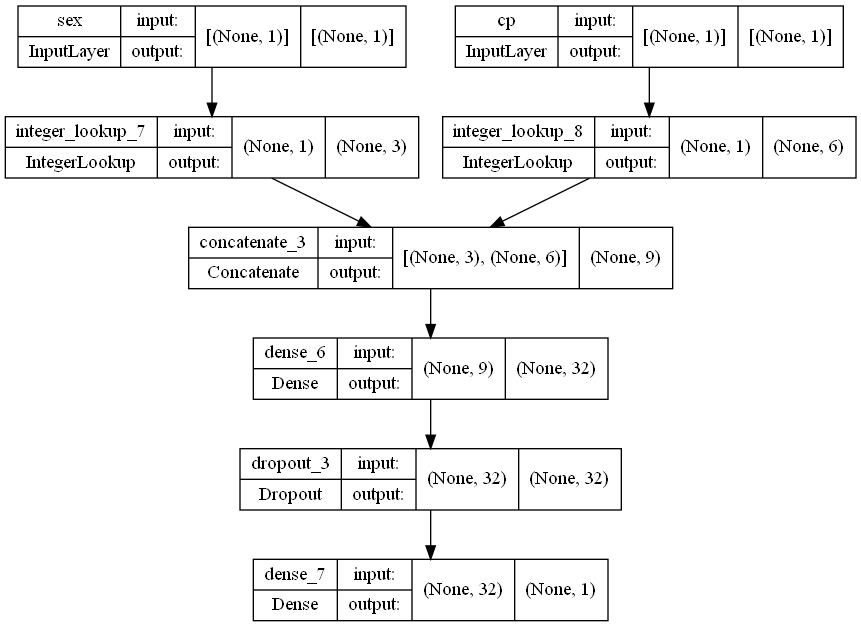

In [48]:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)
# keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)
# keras.utils.plot_model(model, to_file='model.png', rankdir="LR")

In [49]:
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
8/8 [==============================] - 1s 27ms/step - loss: 0.6582 - accuracy: 0.6033 - val_loss: 0.6342 - val_accuracy: 0.7705
Epoch 2/50
8/8 [==============================] - 0s 11ms/step - loss: 0.6663 - accuracy: 0.6074 - val_loss: 0.6135 - val_accuracy: 0.7705
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.6607 - accuracy: 0.6570 - val_loss: 0.5958 - val_accuracy: 0.7705
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.6283 - accuracy: 0.7025 - val_loss: 0.5806 - val_accuracy: 0.7705
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.6279 - accuracy: 0.6736 - val_loss: 0.5673 - val_accuracy: 0.7705
Epoch 6/50
8/8 [==============================] - 0s 9ms/step - loss: 0.5873 - accuracy: 0.7149 - val_loss: 0.5558 - val_accuracy: 0.7705
Epoch 7/50
8/8 [==============================] - 0s 9ms/step - loss: 0.5903 - accuracy: 0.6983 - val_loss: 0.5447 - val_accuracy: 0.7705
Epoch 8/50
8/8 [================

## use custom model

In [ ]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = layers.Conv2D(32, 3, activation='relu')
        self.flatten = layers.Flatten()
        self.d1 = layers.Dense(128, activation='relu')
        self.d2 = layers.Dense(10, activation='softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)